### Plotting the mobility evolution in a selection of countries

c:\Users\val31\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


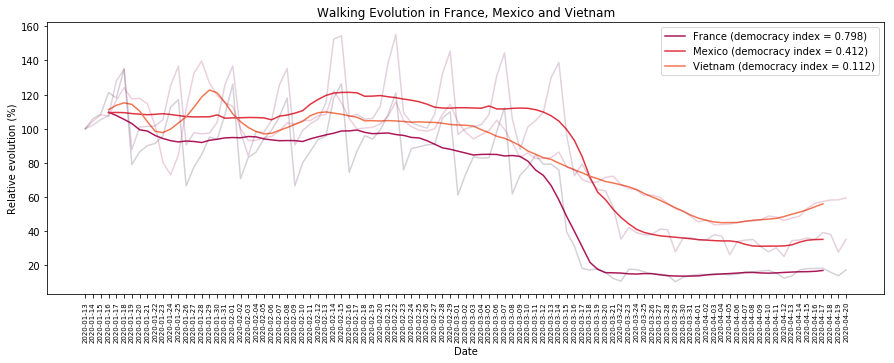

In [ ]:
#Exemple : plot walking evolution in France

import matplotlib.pyplot as plt

#Getting sns colors
colors = sns.color_palette("rocket")

#Extract walking data for France
france_walking = df_apple_mobility[(df_apple_mobility['region']=='France') & (df_apple_mobility['transportation_type']=='walking')]
france_walking.drop(['geo_type', 'region', 'transportation_type'], inplace=True, axis=1)

#Extract data for Mexico
mexico_walking = df_apple_mobility[(df_apple_mobility['region']=='Mexico') & (df_apple_mobility['transportation_type']=='walking')]
mexico_walking.drop(['geo_type', 'region', 'transportation_type'], inplace=True, axis=1)


#Extract data for Vietnam
vietnam_walking = df_apple_mobility[(df_apple_mobility['region']=='Vietnam') & (df_apple_mobility['transportation_type']=='walking')]
vietnam_walking.drop(['geo_type', 'region', 'transportation_type'], inplace=True, axis=1)

#Transpose it to have a pandas series and plot it
france_walking = france_walking.transpose()
mexico_walking = mexico_walking.transpose()
vietnam_walking = vietnam_walking.transpose()
fig = plt.figure(figsize=(15, 5))
plt.plot(france_walking.rolling(7, center=True).mean(), color=colors[2], label='France (democracy index = 0.798)')
plt.plot(mexico_walking.rolling(7, center=True).mean(), color = colors[3], label='Mexico (democracy index = 0.412)')
plt.plot(vietnam_walking.rolling(7, center=True).mean(), color = colors[4], label='Vietnam (democracy index = 0.112)')
plt.plot(france_walking, alpha=.2, color=colors[0])
plt.plot(mexico_walking, alpha=.2, color=colors[1])
plt.plot(vietnam_walking, alpha=.2, color=colors[2])
plt.xticks(fontsize=7, rotation=90)
plt.title('Walking Evolution in France, Mexico and Vietnam')
plt.xlabel('Date')
plt.ylabel('Relative evolution (%)')
plt.legend()
plt.savefig('images/walking_evolution_fr_me_viet.png')
plt.show()

### Clustering countries on the typology of their restrictions

For each country, create an associated vector containing the mobility drop for each category. The goal is to cluster countries based on these values to evaluate the restrictions typology and compare it with the democracy index

In [ ]:
#Number of days on which we apply the rolling mean
nb_days_period = 14

#Create an empty dictionnary to store the results
dict_restrictions = {}

#Mobility categories which will be taken into account
categories = ['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', \
    'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']

#Iterate over all countries
for country in df_google_mob_dem_index['country_region'].unique() :
    #Keep only the values with sub_region_1 is NaN as it corresponds to data for the whole country
    df_country = df_google_mob_dem_index[(df_google_mob_dem_index['country_region'] == country) & (df_google_mob_dem_index['sub_region_1'].isnull())]
    #This list will contain the change between the lowest and the highest period for each category
    changes_list = []

    for category in categories :
        #Extract the data corresponding to this category
        category_data = df_country[category]
        #Compute the highest and the lowest periods
        highest_period_value = category_data.iloc[:30].rolling(nb_days_period).mean().max()
        lowest_period_value = category_data.rolling(nb_days_period).mean().min()
        #Compute the mobility change and add it to the list
        category_change = lowest_period_value - highest_period_value
        changes_list.append(category_change)

    #Add the corresponding entry to the dictionnary
    dict_restrictions[country] = changes_list


Convert the dictinnary dict_restrictions into an array to use in order to use kmeans

In [ ]:
#Import the corresponding modules
from sklearn.cluster import KMeans

#Convert the dictionnary into an array to use it with kmeans
restrictions_array = np.empty((0, len(categories)))
countries = []

#Iterate over all countries
for country in (dict_restrictions.keys()) :
    country_restrictions = np.array(dict_restrictions[country])

    #Check if the row of the corresponding country contains nan values
    if np.isnan(country_restrictions).any() :
        print ('Country containing nan values')
        print (country)

    #If no nan values add it to the array
    else :
        countries.append(country)
        restrictions_array = A = np.vstack([restrictions_array, country_restrictions])


Country containing nan values
Guinea-Bissau [-46.64285714          nan          nan -36.57142857]


Use the elbow method to evaluate the best number of clusters

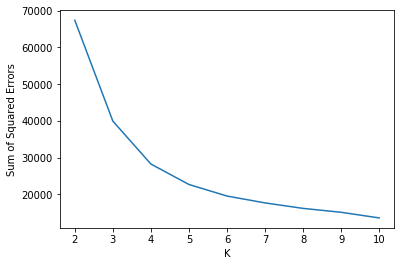

In [ ]:
#Define a function which plots the sse

def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

#Apply it to our data
plot_sse(restrictions_array)



Cluster the data with KMeans, with 5 clusters

In [ ]:
#The best number of clusters is taken equal to 5
n_clusters = 5

#Performing k_means
kmean = KMeans(n_clusters=n_clusters, random_state=2).fit(restrictions_array)


['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']
[[-74.19933555 -49.73089701 -74.1013289  -62.67607973]
 [-34.02142857 -21.00714286 -40.91071429 -32.40357143]
 [-85.15714286 -69.57428571 -82.91428571 -78.62857143]
 [-57.41991342 -34.43073593 -60.62121212 -51.4025974 ]
 [-12.69642857  -4.46428571 -11.32142857 -16.94642857]]


Create a plot summarizing the restrictions for the centroid of each cluster

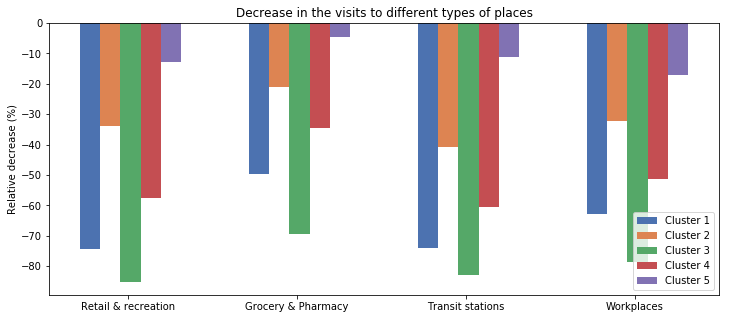

In [ ]:
#Create a plot summurizing the centroid of each cluster

#Create the figure
plt.figure(figsize=(12, 5))

#Create the categories for the X axis
X = ['Retail & recreation','Grocery & Pharmacy','Transit stations','Workplaces']
X_axis = np.arange(len(X))

#Use seaborn colors
colors = sns.color_palette('deep')

#Create the bar plots
for i in range (kmean.cluster_centers_.shape[0]) :
    plt.bar(X_axis + 0.12*i, kmean.cluster_centers_[i,:], 0.12, label = 'Cluster '+str(i+1), color=colors[i])

#Titles, legends etc
plt.xticks(X_axis+.15*1.5, X)
plt.title("Decrease in the visits to different types of places")
plt.ylabel("Relative decrease (%)")
plt.legend(loc = 'lower right')
plt.savefig('images/categories_change.png')
plt.show()



Count the number of countries in each bin for democracy index. A bin is for instace [0.3, 0.4[ . The goal of this is to then comput the proportion of countries in each cluster of each bin.

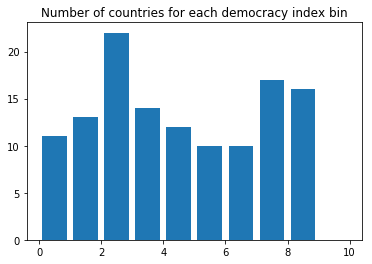

In [ ]:
import math

#Create a list with the democracy indexes of all the countries
all_dem_indexes = []

#Create a list with all the democracy indexes
for country in countries :
    dem_index = df_google_mob_dem_index['dem_index'][df_google_mob_dem_index['country_region']==country].iloc[0]
    all_dem_indexes.append(dem_index)

#Count the number of countries in each bin using the previously created list
countries_dem_index_bins = np.zeros(10)

for i in range (len(all_dem_indexes)) :
    dem_index = all_dem_indexes[i]
    bin = math.floor(dem_index*10)
    countries_dem_index_bins[bin] += 1


#Plot the results
plt.bar([.5+i for i in range(10)], countries_dem_index_bins)
plt.title('Number of countries for each democracy index bin')
plt.xlabel('Democracy index x10')
plt.ylabel('Number of countries')
plt.show()

Display detailed informations for each clusters

Cluster 1 :
['United Arab Emirates', 'Austria', 'Bosnia and Herzegovina', 'Bangladesh', 'Belgium', 'Chile', 'Costa Rica', 'Cape Verde', 'Dominican Republic', 'Egypt', 'France', 'United Kingdom', 'Ghana', 'Greece', 'Guatemala', 'Croatia', 'Ireland', 'Israel', 'Iraq', 'Italy', 'Kazakhstan', 'Lebanon', 'Luxembourg', 'Moldova', 'North Macedonia', 'Malta', 'Malaysia', 'Namibia', 'Poland', 'Portugal', 'Paraguay', 'Romania', 'Russia', 'Rwanda', 'Saudi Arabia', 'Slovenia', 'Slovakia', 'Turkey', 'Trinidad and Tobago', 'Ukraine', 'Uganda', 'Venezuela', 'Zimbabwe']


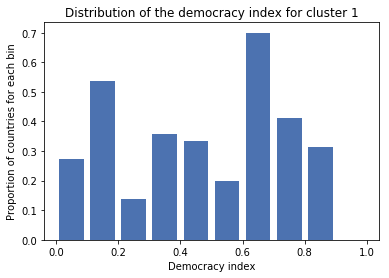

Mean democracy index : 0.4755348837209302
Median democracy index : 0.47600000000000003 

Restrictions_characteristics
retail_and -74.19933554817275 %
grocery_an -49.73089700996678 %
transit_st -74.10132890365449 %
workplaces -62.67607973421927 %


Cluster 2 :
['Burkina Faso', 'Bahrain', 'Benin', 'Belarus', 'Cameroon', 'Haiti', 'Japan', 'Cambodia', 'Latvia', 'Mali', 'Mozambique', 'Niger', 'Papua New Guinea', 'Sweden', 'Senegal', 'Togo', 'Thailand', 'Tanzania', 'Yemen', 'Zambia']


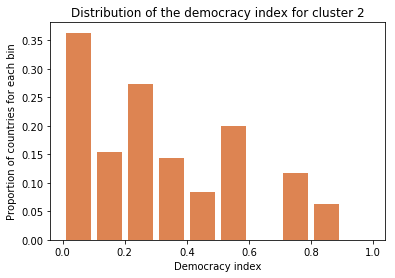

Mean democracy index : 0.3256
Median democracy index : 0.27349999999999997 

Restrictions_characteristics
retail_and -34.02142857142858 %
grocery_an -21.007142857142856 %
transit_st -40.910714285714285 %
workplaces -32.40357142857143 %


Cluster 3 :
['Argentina', 'Barbados', 'Bolivia', 'Botswana', 'Colombia', 'Ecuador', 'Spain', 'Georgia', 'Honduras', 'India', 'Jordan', 'Kyrgyzstan', 'Kuwait', 'Sri Lanka', 'Morocco', 'Mauritius', 'Nepal', 'New Zealand', 'Panama', 'Peru', 'Philippines', 'Pakistan', 'Serbia', 'El Salvador', 'South Africa']


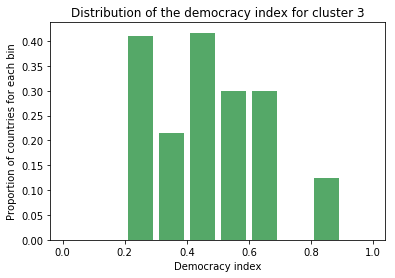

Mean democracy index : 0.44404
Median democracy index : 0.462 

Restrictions_characteristics
retail_and -85.15714285714286 %
grocery_an -69.57428571428572 %
transit_st -82.91428571428571 %
workplaces -78.62857142857143 %


Cluster 4 :
['Afghanistan', 'Angola', 'Australia', 'Bulgaria', 'Brazil', 'Canada', 'Switzerland', 'Czechia', 'Germany', 'Denmark', 'Estonia', 'Finland', 'Fiji', 'Gabon', 'Hungary', 'Indonesia', 'Jamaica', 'Kenya', 'Laos', 'Lithuania', 'Libya', 'Mexico', 'Nigeria', 'Nicaragua', 'Netherlands', 'Norway', 'Oman', 'Qatar', 'Singapore', 'Tajikistan', 'United States', 'Uruguay', 'Vietnam']


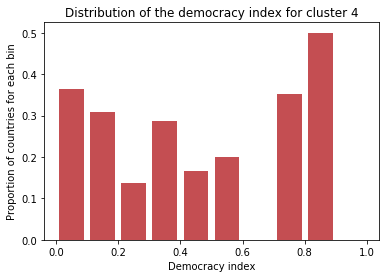

Mean democracy index : 0.4850909090909091
Median democracy index : 0.446 

Restrictions_characteristics
retail_and -57.41991341991342 %
grocery_an -34.430735930735935 %
transit_st -60.62121212121212 %
workplaces -51.4025974025974 %


Cluster 5 :
['Hong Kong', 'South Korea', 'Mongolia', 'Taiwan']


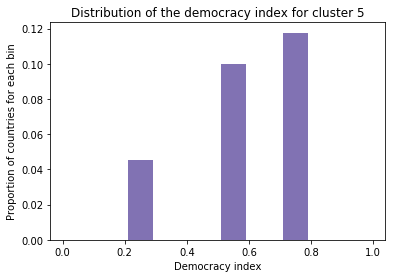

Mean democracy index : 0.5685
Median democracy index : 0.6174999999999999 

Restrictions_characteristics
retail_and -12.696428571428577 %
grocery_an -4.464285714285715 %
transit_st -11.321428571428562 %
workplaces -16.94642857142857 %




In [ ]:
#For each cluster, find the corresponding countries and the mean democracy index

#Getting sns colors for plots
colors = sns.color_palette('deep')

#Iterate over the 5 clusters
for i in range (n_clusters) :

    #Print all the countries which are in the current cluster
    countries_cluster = [] 
    for j in range (kmean.labels_.shape[0]) :
        if kmean.labels_[j] == i :
            countries_cluster.append(countries[j])

    print ('Cluster', i+1, ':')
    print (countries_cluster)

    #Compute the mean and median democracy index of the corresponding cluster
    dem_indexes = []
    for country in countries_cluster :
        dem_index = df_google_mob_dem_index['dem_index'][df_google_mob_dem_index['country_region']==country].iloc[0]
        dem_indexes.append(dem_index)

    mean_dem_index = np.mean(np.array(dem_indexes))
    median_dem_index = np.median(np.array(dem_indexes))

    print ('Mean democracy index :', mean_dem_index)
    print ('Median democracy index :', median_dem_index, '\n')

    #Print the restrictions for the centroid of the cluster
    print ('Restrictions_characteristics')
    for j in range (len(categories)) :
        print (categories[j], kmean.cluster_centers_[i, j], '%')
    
    #For the current cluster, compute for each democracy index bin the proportion of countries contained in the cluster
    cluster_dem_indexes_bins = np.zeros(10)
    for j in range (len(dem_indexes)) :
        dem_index = dem_indexes[j]
        bin = math.floor(dem_index*10)
        cluster_dem_indexes_bins[bin] += 1/ countries_dem_index_bins[bin]
    
    #Plot the corresponding ditribution
    plt.figure(figsize=(6, 4))
    plt.bar([.05+i*.1 for i in range(10)], cluster_dem_indexes_bins, 0.08, color = colors[i])
    plt.xlabel('Democracy index')
    plt.ylabel('Proportion of countries for each bin')
    plt.title('Distribution of the democracy index for cluster ' + str(i+1))
    filename = 'images/cluster_' + str(i+1) + '.png'
    plt.savefig(filename)
    plt.show()

    print ('\n')
